In [100]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

class Newtonian(pybamm.BaseModel):
    def __init__(self, param, name= "Newtonian model"):
        super().__init__(name=name) #This initiaties the inherited class
        self.param = param

        ##################
        #Define parameter
        ##################
        #for velocity_profile and thickness_convergence
        P = pybamm.Parameter("Pressure [Pa]")
        U = pybamm.Parameter("Coating speed [ms-1]")

        #for viscosity_profile
        mu = pybamm.Parameter("Newtionian viscosity [Pa]")
        gamma = pybamm.Parameter("Shear strain [s-1]")
        m = pybamm.Parameter("Exponent parameter [t]")

        #for analytical coating thickness
        A_1 = pybamm.Parameter("Integration constant 1")
        A_2 = pybamm.Parameter("Integration constant 2")
        H_g = pybamm.Parameter("Coating Gap [m]")
        n = pybamm.Parameter("Power-law index")

        #################
        #Define variables
        #################
        #for velocity_profile and thickness_convergence
        u = pybamm.Variable("Velocity  [ms-1]", domain = "coating")
        y = pybamm.SpatialVariable("y [m]", domain="coating", coord_sys="cartesian")

        ####################
        #Governing equations
        ####################
        #for velocity_profile and thickness_convergence
        grad = pybamm.grad(u)
        self.algebraic[u] = pybamm.div(grad)-P

        #for viscosity_profile
        self.variables["Shear stress [Pa]"] = u*gamma
        
        #for analytical coating thickness
        self.variables["Analytical tape thickness [mm]"] = (-(-P*H_g+A_1)**(1/n+2)-(A_1)**(1/n+2))/(U*P*(-1/P*mu**(1/n))*(1/(n+1))*(1/(n+2)))+A_2*H_g

        ####################
        #Boundary conditions
        ####################
        #for velocity_profile and thickness_convergence
        self.boundary_conditions = {u: {"left": (U, "Dirichlet"), "right": (0, "Dirichlet")}}
        self.initial_conditions = {u: U}

        ##################
        #Output variables
        ##################
        self.variables.update({
            "Velocity  [ms-1]": u,
            "Coating thickness [m]": pybamm.Integral(u, y)/U,
            "y [m]": y,
        })
    
    @property
    def default_geometry(self):
        H_g = pybamm.Parameter("Coating Gap [m]")
        y = self.variables["y [m]"]
        return {"coating": {y: {"min": pybamm.Scalar(0), "max": H_g}}}
    
    @property
    def default_var_pts(self):
        y = self.variables["y [m]"]
        return {y: 20}
    
    @property
    def default_submesh_types(self):
        return {"coating": pybamm.Uniform1DSubMesh}
    
    @property
    def default_spatial_methods(self):
        return {"coating": pybamm.FiniteVolume()}
    
    def analytical_thickness(self, plot = 0):

        if plot == 0:
            #Plots the solution to the model over a range of shear strain values
            sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
            sol = sim.solve([0, 1])
            return sol["Analytical tape thickness [mm]"].entries[0]
        
        elif plot == 1:
            
            #Add parameters
            orig_blade_h = self.param["Coating Gap [m]"] #store the original value of the pressure so that it can be looped over in the funtion
            self.param["Coating Gap [m]"] = "[input]"
            orig_speed = self.param["Coating speed [ms-1]"] #store the original value of the pressure so that it can be looped over in the funtion
            self.param["Coating speed [ms-1]"] = "[input]"

            v_0_values = np.linspace(0, 20, 10)
            tape_thickness_h = []
            values = [0,0.1,0.5,1]

            #Loop over each m value and plot
            for j in values:
                self.param["Coating Gap [m]"] = j

                #Plots the solution to the model over a range of shear strain values for the given m value
                for i in v_0_values:
                    sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
                    sol = sim.solve([0, 1], inputs={"Coating speed [ms-1]":i})
                    print(sol['Coating thickness [m]'].entries[0])
                    tape_thickness_h.append(sol['Coating thickness [m]'].entries[0])
                
                plt.plot(v_0_values, tape_thickness_h, label = "h={}".format(j))
                tape_thickness_h = []

            #Figure labels
            plt.xlabel(r"$v_0$ [mm/s]")
            plt.ylabel(r"$\delta$ [mm]")
            plt.legend()

            #Figure caption
            txt="Figure 2: Variation of the tape thickness by the substrate velocity"
            plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
            plt.figure()
            
            self.param["Coating Gap [m]"] = orig_blade_h
            self.param["Coating speed [ms-1]"] = orig_speed
                
            return 
        
    
    def velocity_profile(self, P_lower=-1, P_upper=4, normalised=0):
        
        #Add parameters
        orig_pressure = self.param['Pressure [Pa]'] #store the original value of the pressure so that it can be looped over in the funtion
        self.param['Pressure [Pa]'] = "[input]"

        sim = pybamm.Simulation(self, parameter_values=self.param)
        solutions = []
        
        U = self.param["Coating speed [ms-1]"]
        H_g = self.param["Coating Gap [m]"]

        for P in range(P_lower,P_upper):
            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": P})
            solutions.append(sol)
            
        for sol in solutions:
            y = sol["y [m]"](t=0)
            u = sol["Velocity  [ms-1]"](t=0)
            if normalised == 0:
                plt.plot(u, y)
                plt.ylim([0, H_g])
                plt.ylabel(r"Height [$\mu m$]")
                plt.xlabel(r"Velocity [$m/min$]")
            elif normalised == 1:
                plt.plot(u/U, y/H_g)
                plt.ylim([0, 1])
                plt.ylabel(r"$y/h$")
                plt.xlabel(r"$u/v_0$")

        #Figure caption
        txt="Figure 1: Results of analytical modelling for a velocity profile below the slot die region with different pressure heads using the" + " {} ".format(self.name)
        plt.figtext(0.5, -0.15, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.legend()
        plt.figure()

        self.param['Pressure [Pa]'] = orig_pressure #restore the original value of the parameter

    def thickness_convergence(self):
        var_pts_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,100,200]
        solutions = []
        thickness_list = []

        for pts in var_pts_list:
            sim = pybamm.Simulation(self, parameter_values=self.param, var_pts={self.variables["y [m]"]: pts})

            sol = sim.solve([0, 1], inputs={"Pressure [Pa]": 5})
            solutions.append(sol)

            thickness_list.append(sol["Coating thickness [m]"](t=0))   

        error_list = []

        for thickness in thickness_list:
            error = abs((self.analytical_thickness() - thickness)/self.analytical_thickness() *100) #need to add absolute value here
            error_list.append(error)  

        # plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4)) 

        ax1.plot(var_pts_list, thickness_list, "o-")
        #ax1.axhline(y = self.analytical_thickness(), color = 'r', linestyle = '--') #thicknesses[-1] has been used as a temporary analytical solution    
        ax1.set_xlabel("Mesh points")
        ax1.set_ylabel(r"Coating thickness [mm]")
        solutions = []

        ax2.axhline(y = 1, color = 'r', linestyle = '--')
        ax2.plot(var_pts_list, error_list)
        ax2.set_ylabel("Percentage error from analytical solution [%]")
        ax2.set_xlabel("Mesh points")
        plt.figure()
    
    def viscosity_profile(self):

        #Add parameters
        orig_shear = self.param["Shear strain [s-1]"]
        self.param["Shear strain [s-1]"] = "[input]"

        values = np.linspace(0, 20, 100)
        shear_stress = []

        #Plots the solution to the model over a range of shear strain values for the given m value
        for i in values:
            sim = pybamm.Simulation(self, parameter_values=self.param, solver=pybamm.DummySolver())
            sol = sim.solve([0, 1], inputs={"Shear strain [s-1]":i})
            shear_stress.append(sol["Shear stress [Pa]"].entries[1])
        
        plt.plot(values, shear_stress)
        shear_stress = []

        plt.figure()

        self.param["Shear strain [s-1]"] = orig_shear


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


RuntimeError: .../casadi/core/slice.cpp:82: Assertion "stop<=len" failed:
Slice (start=0, stop=20, step=1) out of bounds with supplied length of 1

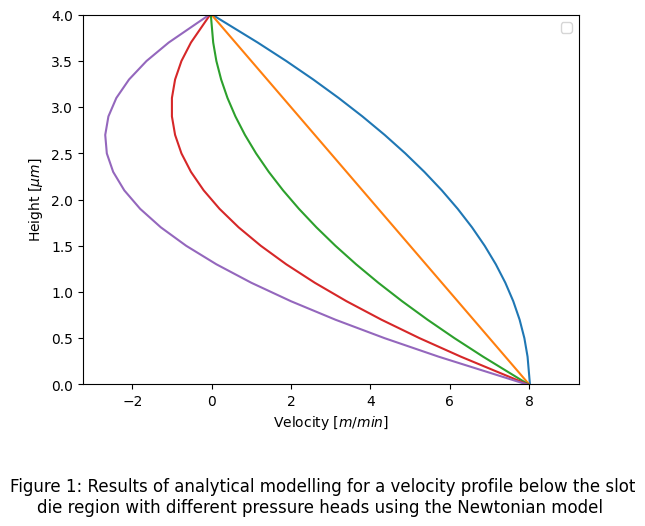

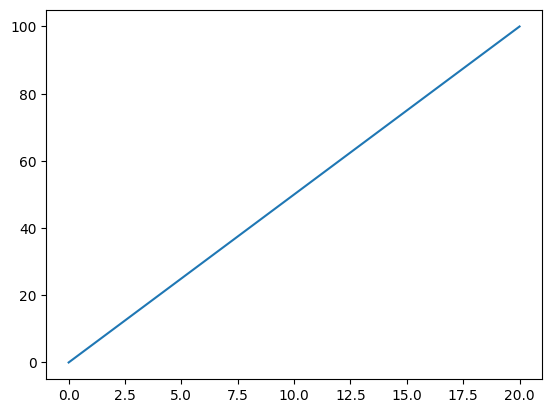

<Figure size 640x480 with 0 Axes>

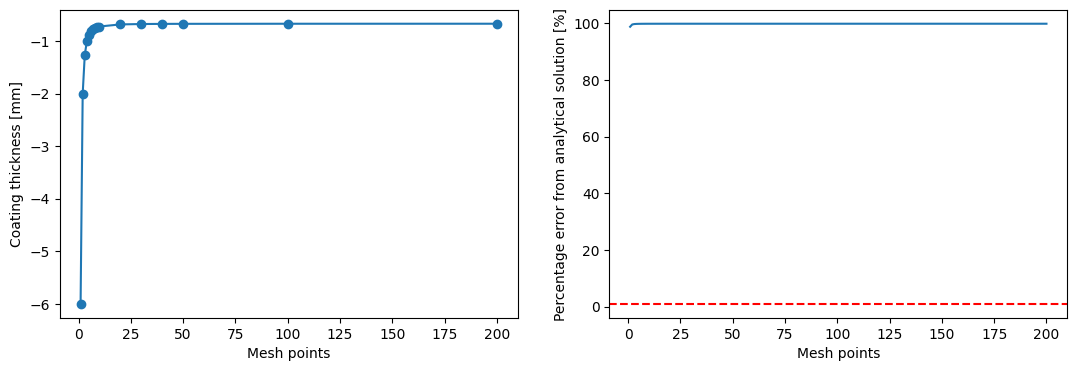

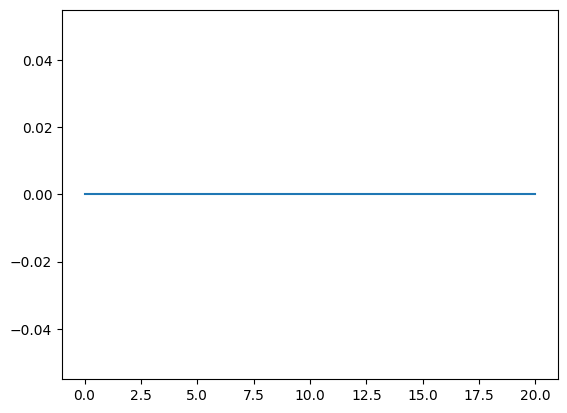

In [103]:
#Add parameters
param = pybamm.ParameterValues(
    {
        "Pressure [Pa]": 4,
        "Yield stress [Pa]": 2,
        "Exponent parameter [t]": 3,
        "Coating Gap [m]": 4,
        "Coating speed [ms-1]": 8,
        "Newtionian viscosity [Pa]": 5,
        "Shear strain [s-1]": 1,
        "Integration constant 1": 1,
        "Integration constant 2": 1.5,

        "Power-law index": 1,

    }
)


model = Newtonian(param=param)
model.velocity_profile(normalised=0)
model.viscosity_profile()
model.thickness_convergence()
model.analytical_thickness(plot =1)